# 📈 Pairs Trading Research Notebook
This notebook performs statistical arbitrage research on a curated set of equity and ETF pairs.
The goal is to identify stable, cointegrated relationships and build a robust mean-reversion
strategy suitable for implementation in QuantConnect's LEAN framework.

We follow a standard quantitative workflow:

1. **Data Collection** – Download daily Close prices for a universe of stocks.
2. **Pair Selection** – Use only economically meaningful and historically stable pairs.
3. **Cointegration Testing** – Estimate hedge ratios via OLS and test spread stationarity using ADF.
4. **Spread Construction** – Build stationary spreads and evaluate mean-reversion strength.
5. **Z-score Analysis** – Determine optimal entry/exit thresholds for trading signals.
6. **Strategy Preparation** – Store computed betas, spreads, and Z-scores for final model.

In [73]:
!pip install yfinance statsmodels numpy pandas matplotlib




[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [74]:
import yfinance as yf
import pandas as pd

tickers = [
    "KO", "PEP",
    "PG", "CL",
    "WMT", "TGT",
    "COST",

    "XOM", "CVX",
    "COP", "MPC",
    "EOG", "DVN",  

    "JPM", "BAC",
    "C", "WFC",
    "MS", "GS",

    "JNJ", "PFE",
    "UNH", "CI",
    "MRK", "BMY",

    "SPY", "IVV",
    "QQQ", "QQQM",
    "VOO",
    "GLD", "IAU", "SLV",

    "VZ", "T"
]


data_all = yf.download(
    tickers=tickers,
    start="2015-01-01",
    end="2025-01-01",
    interval="1d",
    progress=False
)["Close"]

data_all = data_all.dropna()  # drop rows with missing values

data_all.tail()



C:\Users\giann\AppData\Local\Temp\ipykernel_24164\805898049.py:31: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_all = yf.download(


Ticker,BAC,BMY,C,CI,CL,COP,COST,CVX,DVN,EOG,...,SLV,SPY,T,TGT,UNH,VOO,VZ,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2024-12-24,43.600803,55.024860,69.083389,275.961029,90.208809,93.862968,953.842712,137.467438,30.588659,116.791115,...,27.020000,596.076904,21.966003,126.805679,497.256958,547.648193,37.236313,70.067413,91.988403,102.633224
2024-12-26,43.767818,55.253498,69.423943,277.458771,90.189278,93.650337,951.176636,137.601242,30.461370,116.385155,...,27.139999,596.116699,21.975574,130.627090,502.218719,547.638306,37.386009,70.233810,92.097595,102.720039
2024-12-27,43.561504,54.948647,69.083389,274.630768,89.642494,93.679329,934.822021,137.620346,30.549494,116.375496,...,26.760000,589.841614,21.879864,129.774689,501.078979,541.961914,37.348579,69.597633,90.976021,102.710403
2024-12-30,43.139057,53.405365,68.489853,271.113037,88.646584,93.843636,917.422729,136.731552,31.303438,116.549477,...,26.430000,583.110596,21.640581,129.343719,498.927246,535.928894,37.049194,68.912521,89.894157,102.015884
2024-12-31,43.178352,53.881687,68.489853,272.098419,88.763756,95.854095,911.513611,138.423126,32.047592,118.482620,...,26.330000,580.989197,21.793720,129.468201,497.021118,533.769226,37.414078,68.746140,89.675797,103.761803


In [75]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import numpy as np

def test_pair(df, x, y):
    """
    Runs OLS hedge ratio, constructs spread, runs ADF.
    
    df: DataFrame of all prices
    x, y: ticker symbols (strings)
    
    Returns:
        p-value (float),
        hedge ratio beta (float)
    """
    
    # Extract series
    X = df[y]   # Independent variable
    Y = df[x]   # Dependent variable

    # OLS regression: Y = alpha + beta*X
    X_const = sm.add_constant(X)
    model = sm.OLS(Y, X_const).fit()
    beta = model.params[1]

    # Build spread: Y - beta * X
    spread = Y - beta * X

    # ADF test on spread
    adf_result = adfuller(spread)
    p_value = adf_result[1]

    return p_value, beta


## 🔐 Cointegration Analysis & Hedge Ratio Estimation

For each pair `(X, Y)`, we estimate the hedge ratio `β` using Ordinary Least Squares (OLS):

\[
X_t = \alpha + \beta Y_t + \epsilon_t
\]

The resulting spread is computed as:

\[
\text{spread}_t = X_t - \beta Y_t
\]

We then apply the Augmented Dickey-Fuller (ADF) test to evaluate whether the spread is stationary.
A low ADF p-value indicates strong mean-reversion, making the pair suitable for trading.

In [76]:
candidate_pairs = [
    # Consumer Staples
    ("KO", "PEP"),
    ("PG", "CL"),
    ("WMT", "TGT"),
    ("COST", "WMT"),

    # Energy
    ("XOM", "CVX"),
    ("COP", "MPC"),
    ("EOG", "DVN"),  # Updated (PXD removed)

    # Banks
    ("JPM", "BAC"),
    ("C", "WFC"),
    ("MS", "GS"),

    # Healthcare / Pharma
    ("JNJ", "PFE"),
    ("UNH", "CI"),
    ("MRK", "BMY"),

    # ETFs
    ("SPY", "IVV"),
    ("QQQ", "QQQM"),
    ("VOO", "IVV"),
    ("GLD", "IAU"),
    ("GLD", "SLV"),

    # Telecom
    ("VZ", "T")
]


results = []

for x, y in candidate_pairs:
    try:
        pval, beta = test_pair(data_all, x, y)
        results.append((x, y, pval, beta))
    except Exception as e:
        print(f"Error with pair ({x}, {y}): {e}")

results_df = pd.DataFrame(results, columns=["X", "Y", "p_value", "beta"])

# Sort by strongest cointegration (lowest p-value)
results_df = results_df.sort_values("p_value")

results_df


C:\Users\giann\AppData\Local\Temp\ipykernel_24164\3727686255.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]
C:\Users\giann\AppData\Local\Temp\ipykernel_24164\3727686255.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]
C:\Users\giann\AppData\Local\Temp\ipykernel_24164\3727686255.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]
C:\Users\giann\AppData\Lo

,X,Y,p_value,beta
15,VOO,IVV,3.366081e-22,0.915012
10,JNJ,PFE,6.677863e-03,0.586996
9,MS,GS,1.414892e-02,0.173565
16,GLD,IAU,3.113212e-02,4.846041
11,UNH,CI,1.150744e-01,1.125886
13,SPY,IVV,1.698523e-01,0.992306
5,COP,MPC,2.617168e-01,0.526007
1,PG,CL,3.269377e-01,1.310242
14,QQQ,QQQM,4.197770e-01,2.423917
12,MRK,BMY,4.460083e-01,-0.810907


## 🔍 Selected Pairs for Strategy Development

Now we pick the pairs with the best p-value and to avoid unstable or non-economic relationships, we keep a curated set of six fundamental pairs across ETFs and sectors.

**Chosen Pairs:**

- **VOO – IVV** (S&P500 ETF arbitrage)
- **GLD – IAU** (Gold ETF arbitrage)
- **JNJ – PFE** (Pharmaceutical giants)
- **MS – GS** (Investment banks)
- **XOM – CVX** (Energy majors)
- **PG – CL** (Consumer staples)

These pairs offer a balance of:
- very high stability (ETF pairs)
- consistent mean-reversion (low p-value)
- diversified exposure across industries


In [77]:
selected_pairs = [
    ("VOO", "IVV"),
    ("GLD", "IAU"),
    ("JNJ", "PFE"),
    ("MS", "GS"),
    ("XOM", "CVX"),
    ("PG", "CL"),
]


## 📊 Spread Construction & Visualization

After computing the hedge ratio, we build the stationary spread for each pair. A stable spread will
oscillate around a long-term mean with no structural drift. This behavior forms the basis for 
profitable mean-reversion trades.

We visualize the spread along with its mean level to examine:

- stability over time  
- amplitude of fluctuations  
- potential structural breaks  


In [78]:
import matplotlib.pyplot as plt
def compute_spread_and_zscore(data, x, y, window=None, plot=True):
    """
    Computes hedge ratio (beta), spread, z-score, and optionally plots them.
    """
    # OLS hedge ratio
    X = data[y]
    Y = data[x]
    X_const = sm.add_constant(X)
    model = sm.OLS(Y, X_const).fit()
    beta = model.params[1]

    # Spread
    spread = Y - beta * X

    # Z-score
    if window is None:
        z = (spread - spread.mean()) / spread.std()
    else:
        rolling_mean = spread.rolling(window).mean()
        rolling_std = spread.rolling(window).std()
        z = (spread - rolling_mean) / rolling_std

    # Plot
    if plot:
        plt.figure(figsize=(14,5))
        plt.plot(spread)
        plt.title(f"Spread {x}-{y} | β={beta:.3f}")
        plt.axhline(spread.mean(), color='black', linestyle='--')
        plt.show()

        plt.figure(figsize=(14,5))
        plt.plot(z)
        plt.axhline(0, color='black')
        plt.axhline(2, color='red', linestyle='--')
        plt.axhline(-2, color='red', linestyle='--')
        plt.title(f"Z-score {x}-{y}")
        plt.show()

    return beta, spread, z


## 🗂 Saving Results for Strategy Logic

For each pair, we store:

- Hedge ratio `β`
- Spread series
- Z-score series

All results are saved in the `pair_results` dictionary for easy retrieval. These values will feed
directly into the signal generation and position sizing rules of the final QuantConnect algorithm.


C:\Users\giann\AppData\Local\Temp\ipykernel_24164\3671325408.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]



=== VOO vs IVV ===


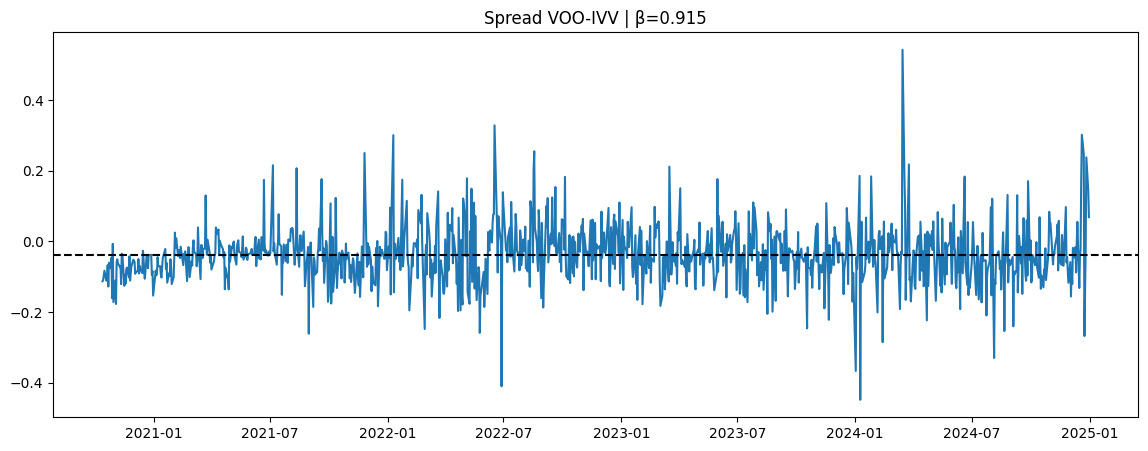

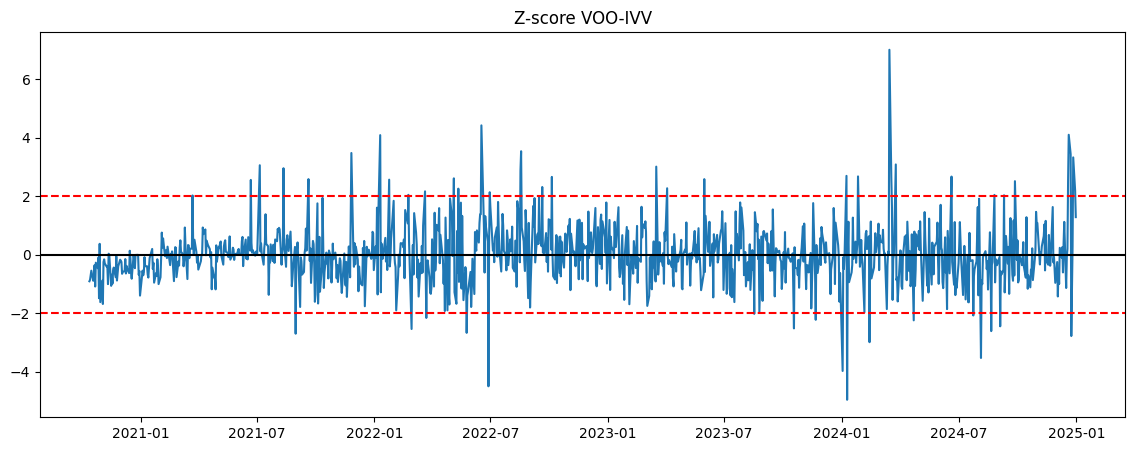


=== GLD vs IAU ===


C:\Users\giann\AppData\Local\Temp\ipykernel_24164\3671325408.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]


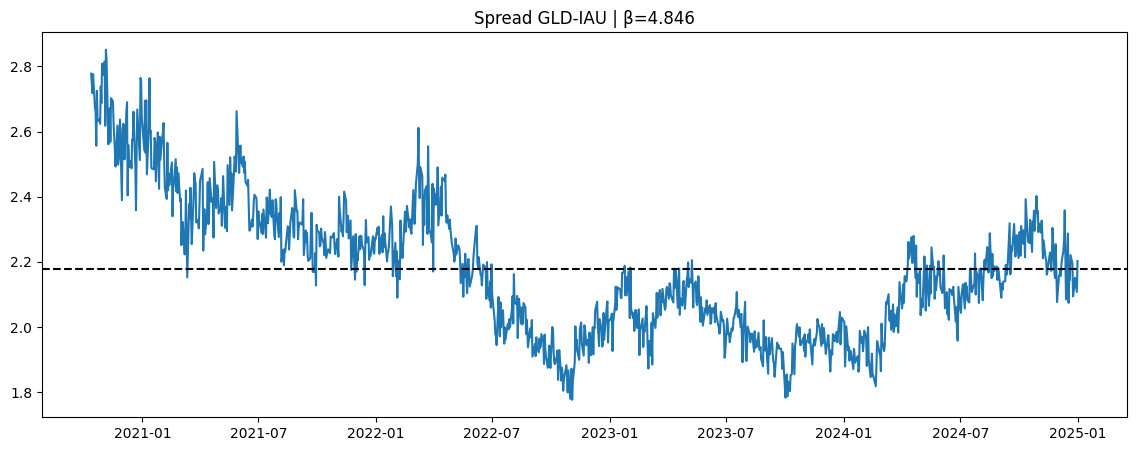

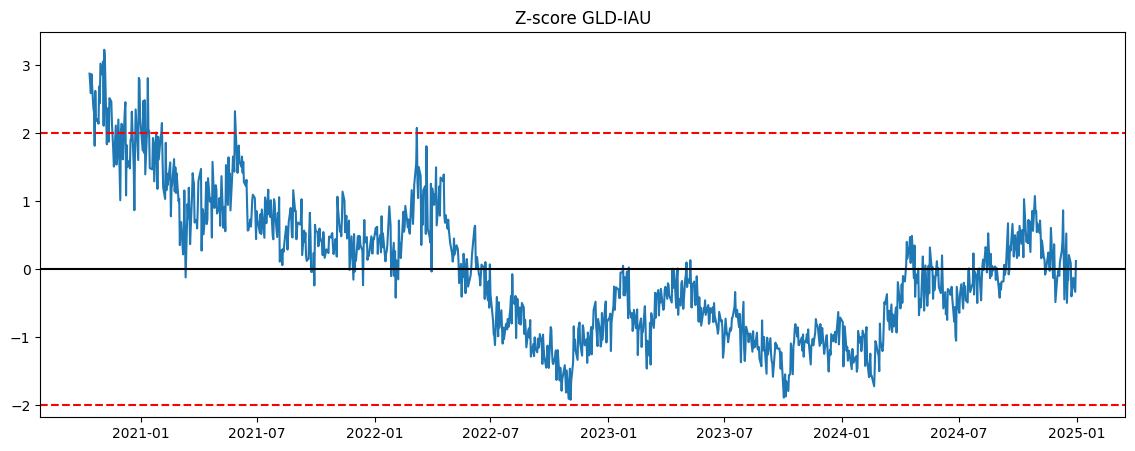


=== JNJ vs PFE ===


C:\Users\giann\AppData\Local\Temp\ipykernel_24164\3671325408.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]


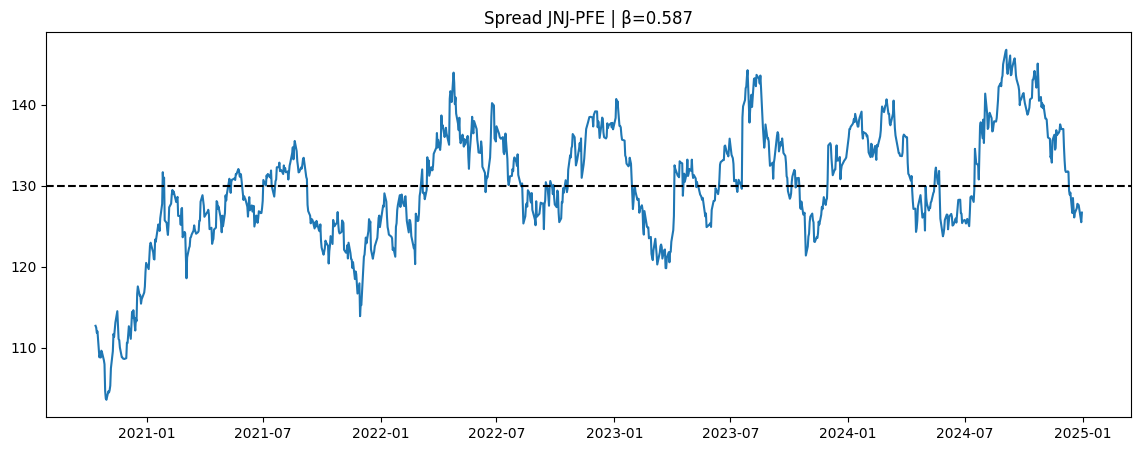

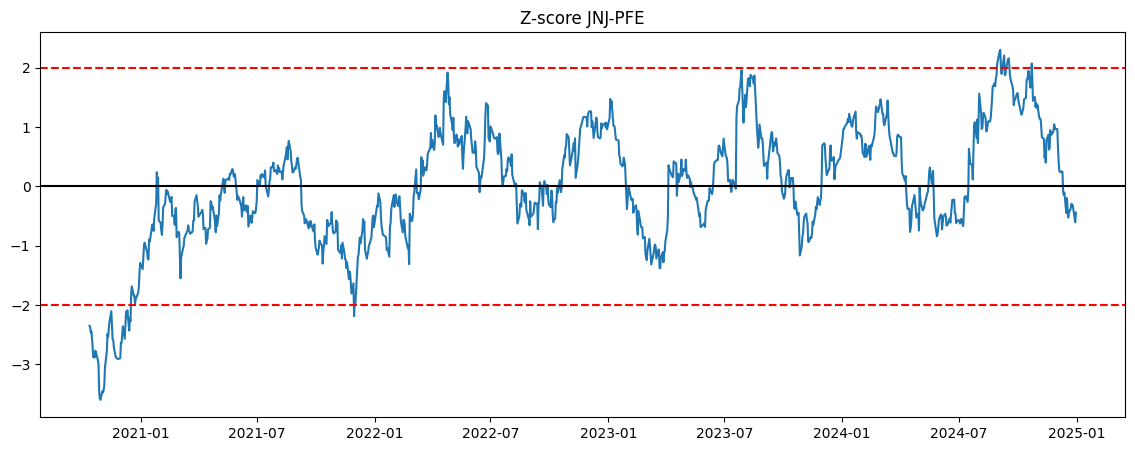


=== MS vs GS ===


C:\Users\giann\AppData\Local\Temp\ipykernel_24164\3671325408.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]


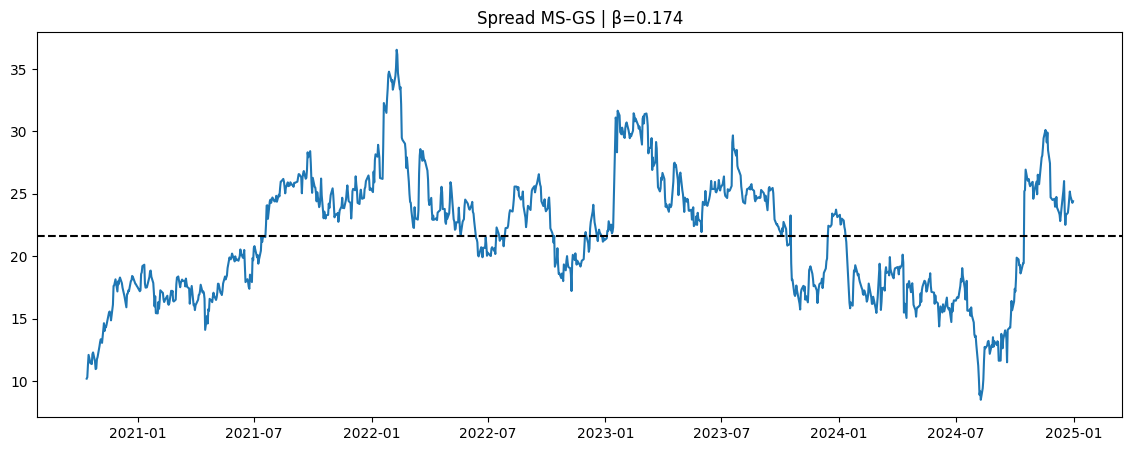

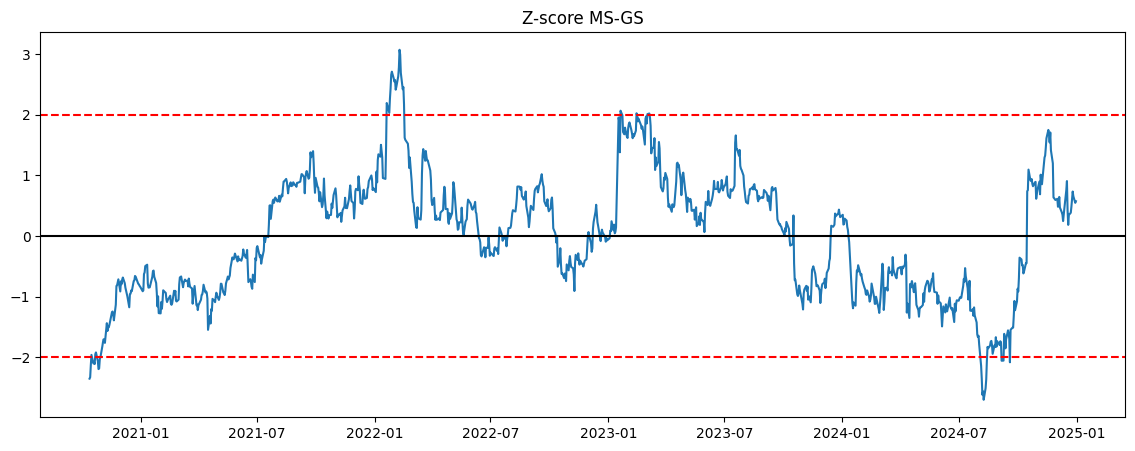


=== XOM vs CVX ===


C:\Users\giann\AppData\Local\Temp\ipykernel_24164\3671325408.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]


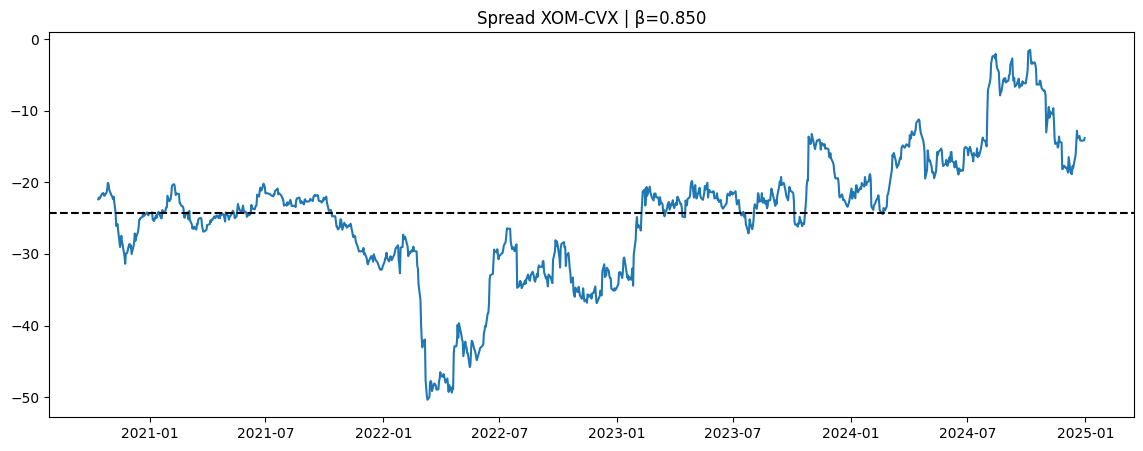

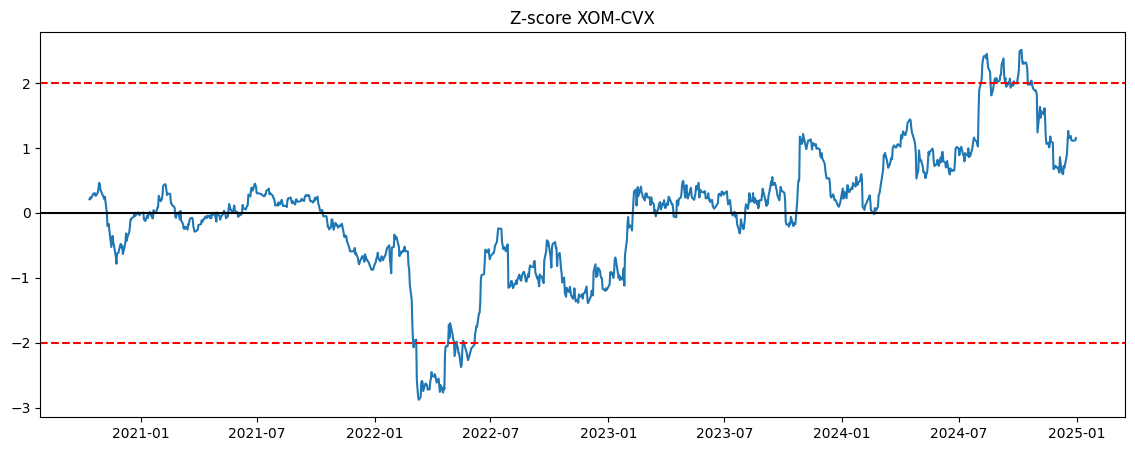


=== PG vs CL ===


C:\Users\giann\AppData\Local\Temp\ipykernel_24164\3671325408.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]


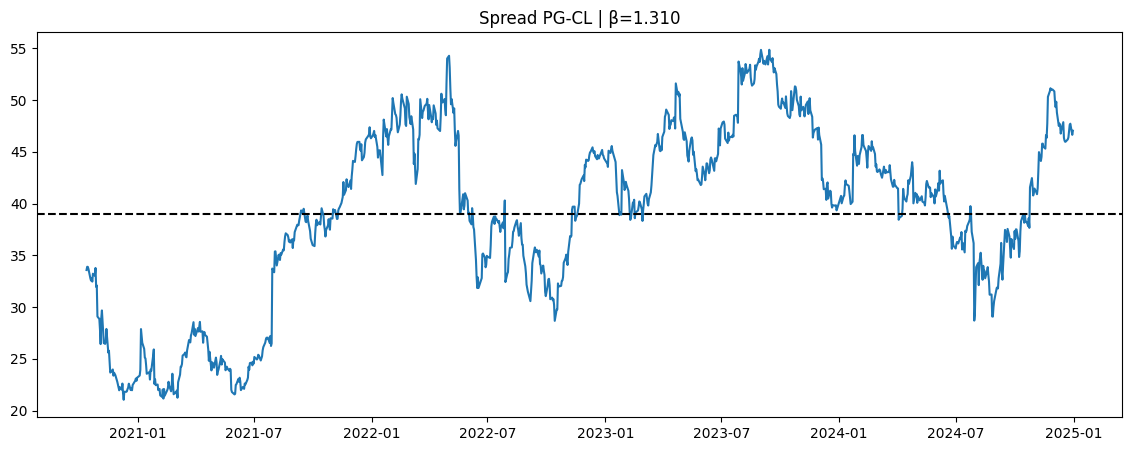

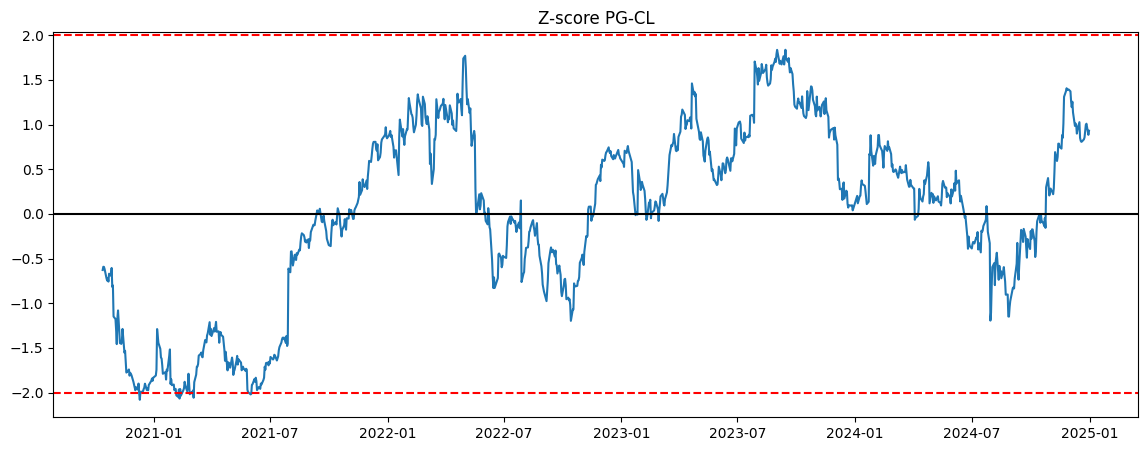

In [79]:
pair_results = {}

for x, y in selected_pairs:
    print(f"\n=== {x} vs {y} ===")
    beta, spread, z = compute_spread_and_zscore(data_all, x, y)
    
    pair_results[(x, y)] = {
        "beta": beta,
        "spread": spread,
        "zscore": z
    }